# Single Run Analysis

Notebook presenting the complete analysis for a single run (run 395). 

In [1]:
import nbimporter
import prepData as prep
import fitFunc as fits
import Statistics as stat

import matplotlib.pyplot as plt
import numpy as np 

## Table of Contents

1. [Load Dataset](#load) <br>
2. [Preliminary Fits](#fits) <br>
    2.1. [Backgroun Fit](#fits_bkg) <br>
    2.2. [Signal Fit](#fits_sig) <br>
3. [Statistical Analysis](#stats) <br>
    3.1. [Significance](#stats_sign) <br>
    3.2. [Confidence Interval](#stats_ci) <br>

## 1. Load Dataset <a name="load"></a>

Load data and prepare it for further analysis using code defined in the "prepData" notebook.

In [2]:
data,center,length = prep.load_dataset(395,"../datasets/")
freq, fft, weights, ref, N = prep.prep_data(data,center, length=length)

Dataset loaded: ../datasets/AnalyzedDataFFT_Run_395_sliced.xlsx
Cavity frequency: 10353468841.0 Hz
fft subrun:2


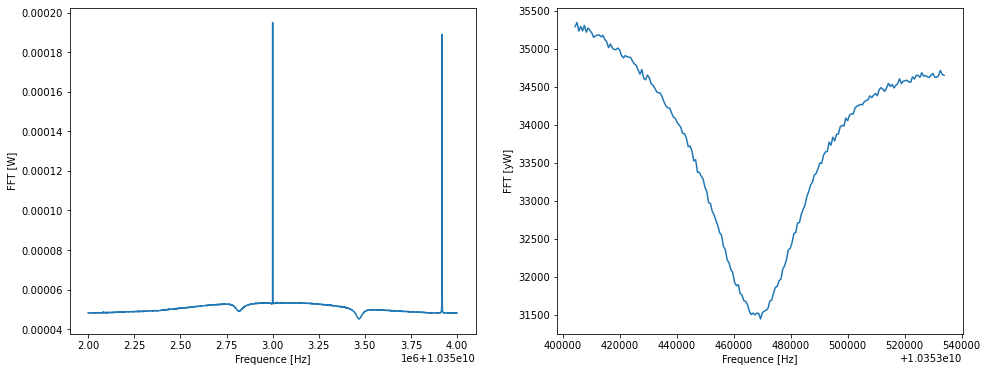

In [3]:
fig,ax= plt.subplots(1,2,figsize=(16, 6))

ax[0].plot(data["freq"], data["fft0"])
ax[0].set_xlabel('Frequence [Hz]')
ax[0].set_ylabel('FFT [W]')

ax[1].plot(freq, fft)
ax[1].set_xlabel('Frequence [Hz]')
ax[1].set_ylabel('FFT [yW]')

plt.show()

## 2. Preliminary Fits <a name="fits"></a>

### 2.1. Background Fit <a name="fits_bkg"></a>

As a preliminary check, we will fit the background function

$$exp \left( 2 \cdot \frac{|x - a+ib|^2}{|x - c+id|^2} + f \cdot (x - c) \right)$$

and study the distribution of residuals.

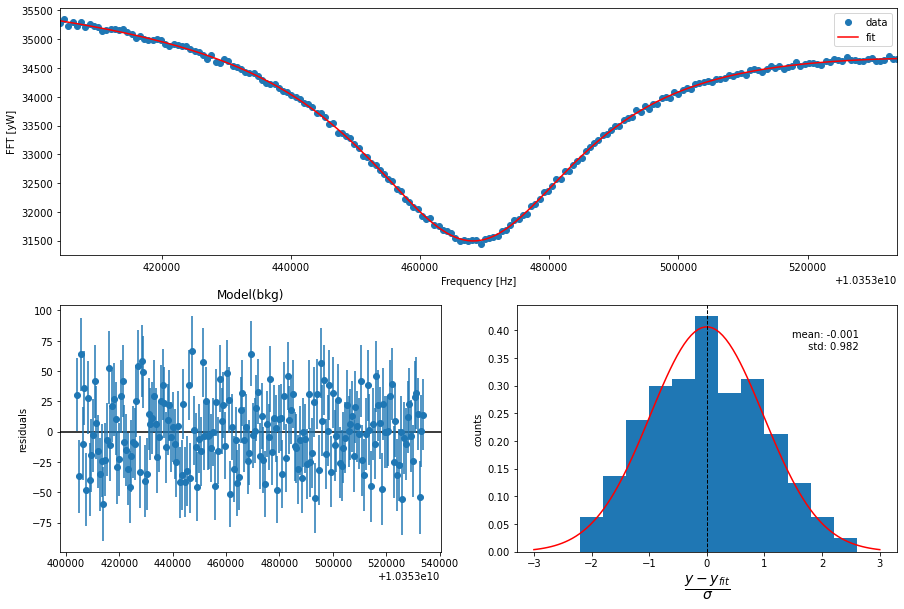

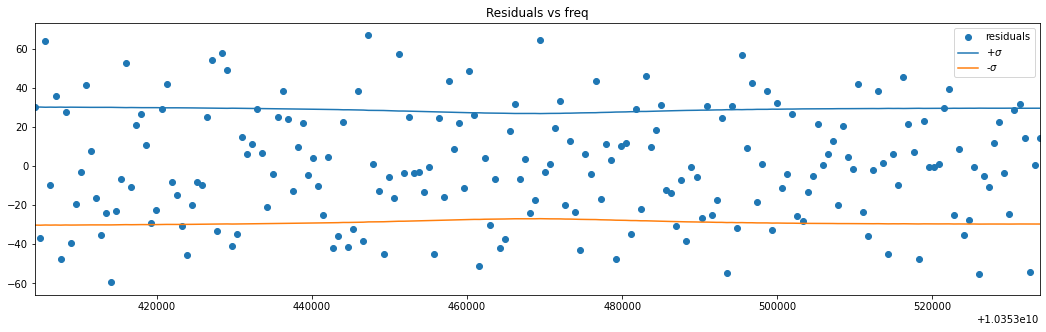

In [4]:
res_bkg = fits.fit_bkg(freq, fft, weights, center, ref)
fits.plot_fit(freq, fft, weights, res_bkg)

### 2.1. Signal Fit <a name="fits_sig"></a>

We will now fit the data with a gaussian signal over the background

$$\mu \cdot exp \left( -\frac{1}{2} \frac{(x - x_0)^2}{\sigma^2} \right)$$

using every possible frequency as the centre of the signal $x_0$.

In [5]:
bkg_params = res_bkg.best_values
res_sig = fits.fit_sig(x=freq, y=fft, w=weights, x_0=freq[199]+50000,
                           init_params=bkg_params, signal=fits.signal_gauss, par_vary=False)

#### $\mu$ analysis

We can study the valye of $\mu_{bestfit}$ w.r.t. $x_0$.

In [6]:
bkg_params = res_bkg.best_values

mu_fit = np.empty(len(freq))
for i in range(len(freq)):
    res_sig = fits.fit_sig(x=freq, y=fft, w=weights, x_0=freq[i],
                           init_params=bkg_params, signal=fits.signal_gauss, par_vary=False)
    mu_fit[i] = res_sig.best_values["mu"]

Text(0, 0.5, '$\\hat{\\mu}$')

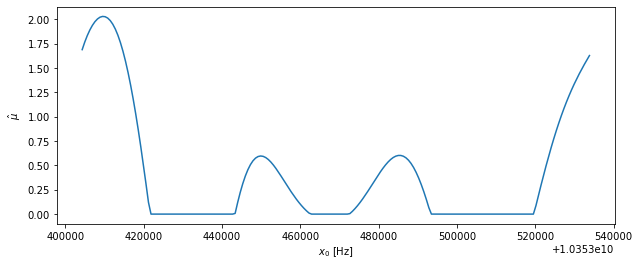

In [7]:
fig = plt.figure(figsize=(10, 4))
plt.plot(freq, mu_fit)
plt.xlabel(r'$x_0$ [Hz]')
plt.ylabel(r'$\hat{\mu}$')

Let us now check the goodness of the fits, using the one returning the maximum $\hat{\mu}$ as an example.

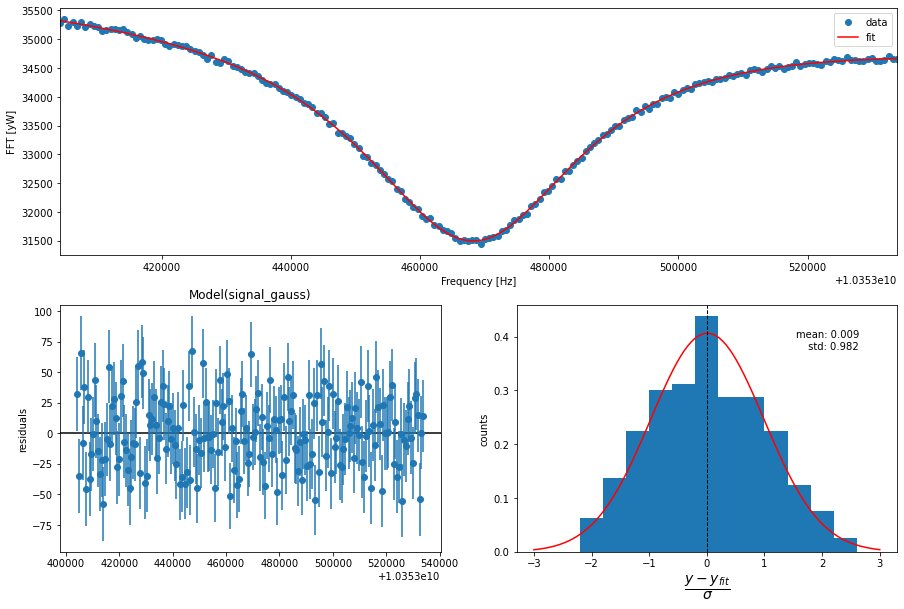

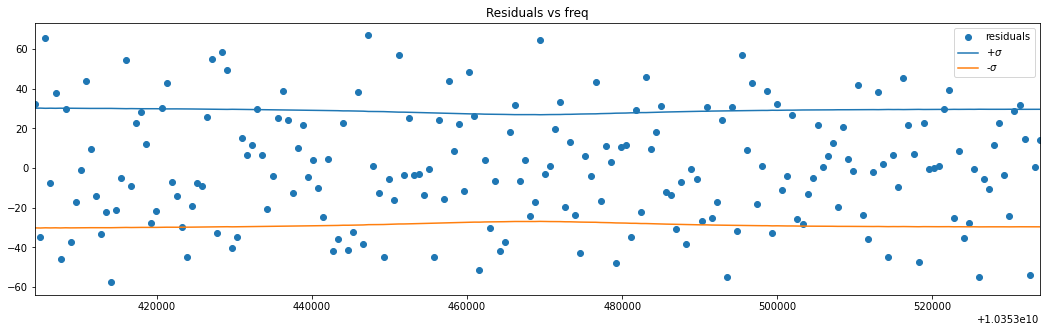

In [8]:
x0_max = freq[np.argmax(mu_fit)]

res_sig = fits.fit_sig(x=freq, y=fft, w=weights, x_0=x0_max,
                       init_params=bkg_params, signal=fits.signal_gauss, par_vary=False)
fits.plot_fit(freq, fft, weights, res_sig)

It is important to note that, if you let every parameter vary, the fit does not converge for $\mu$ and it gets stuck on the starting value.

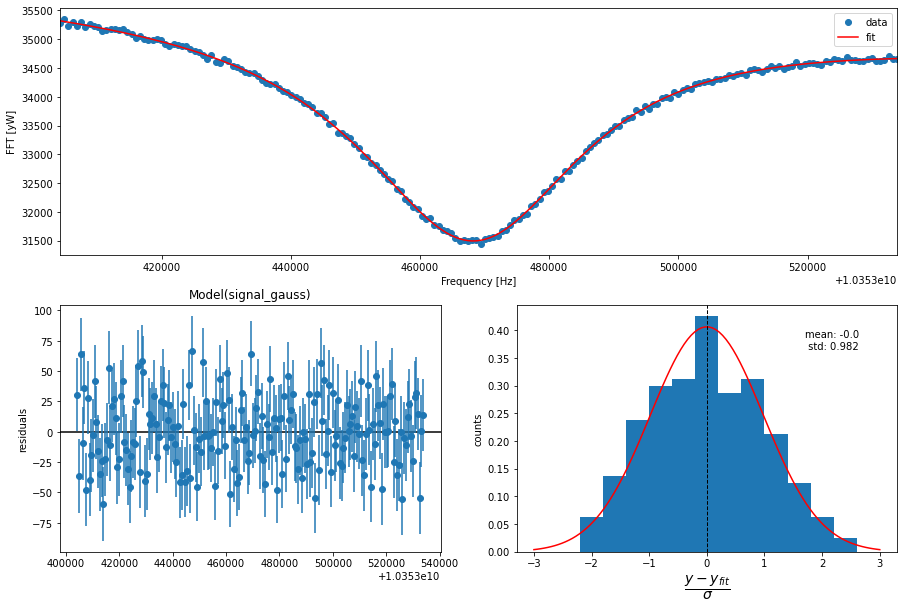

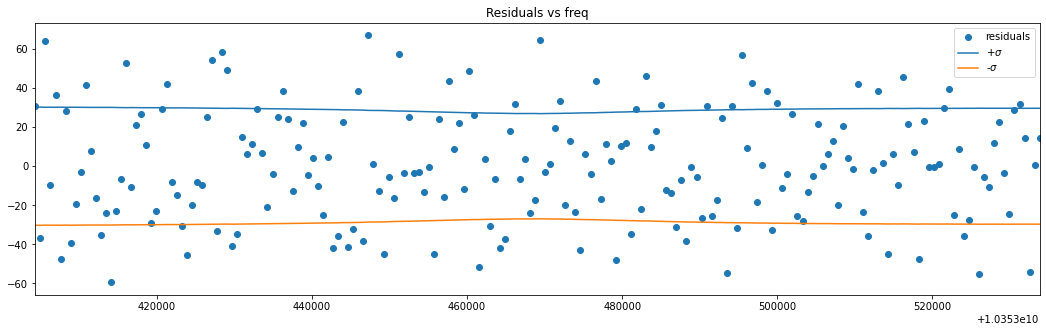

In [9]:
res_sig = fits.fit_sig(x=freq, y=fft, w=weights, x_0=x0_max,
                       init_params=bkg_params, signal=fits.signal_gauss, par_vary=True, mu_init=0.1)
fits.plot_fit(freq, fft, weights, res_sig)

## 3. Statistical Analysis <a name="stats"></a>

### 3.1. Significance <a name="stats_sign"></a>

Assuming the presence of a signal, we will now compute its significance. As more thoroughly explained in the "Statistics" notebook, this quantity is computed from the p-value of the observed likelihood ratio

$$q_0^{obs} = -2 \cdot \log \left( \cfrac{\mathcal{L} \left(Data | 0, \hat{\theta}_0 \right)}{\mathcal{L} \left(Data | \hat{\mu}, \hat{\theta}_\hat{\mu} \right)}\right)$$

with respect to a distribution ob of $q_0$ obtained from toy datasets.  
Every recorded frequency is investigated as a possible center of the signal, $x_0$. 

In [12]:
z_tot, _ = stat.stat_test(run=395, x_0=freq, mu_fix=0,
                          signal=fits.signal_gauss, n_toy=1000,
                          calc_z=True, calc_CI=False, draw=False, verbose=False, path='../datasets/')

Dataset loaded: ../datasets/AnalyzedDataFFT_Run_395_sliced.xlsx
Cavity frequency: 10353468841.0 Hz
fft subrun:2
Step: 20
Step: 40
Step: 60
Step: 80
Step: 100
Step: 120
Step: 140
Step: 160
Step: 180
Step: 200


The highest significance is 1.27 found at 10353412760.416666 Hz


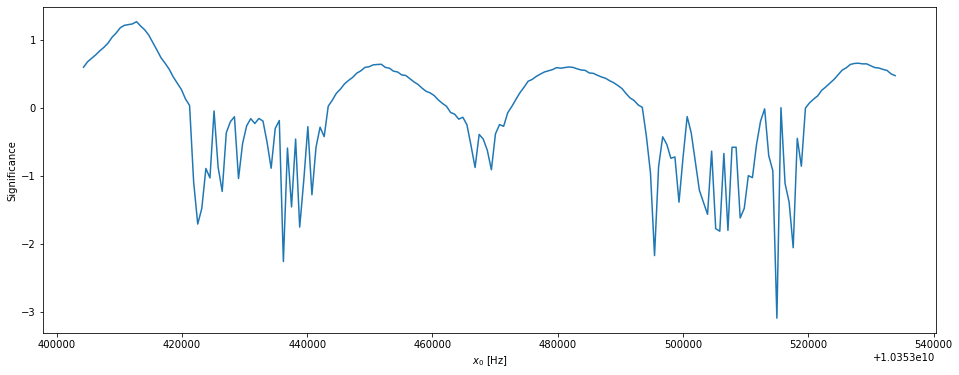

In [21]:
fig = plt.figure(figsize=(16, 6))
plt.plot(freq, z_tot)
plt.xlabel(r'$x_0$ [Hz]')
plt.ylabel('Significance')

max_z = np.max(z_tot)
freq_max_z = freq[z_tot == max_z].values

print("The highest significance is", round(max_z, 2), "found at", freq_max_z[0], "Hz")

The highest significance found is too small to refute the *background-only* hypothesis.

Here are three examples of the likelihood ratio distribution obtained from toy data for different choices of $x_0$:

- the frequency corresponding to the maximum value of $\hat{\mu}$
- the center of the cavity
- a secondary peak of $\hat{\mu}$

Dataset loaded: ../datasets/AnalyzedDataFFT_Run_395_sliced.xlsx
Cavity frequency: 10353468841.0 Hz
fft subrun:2


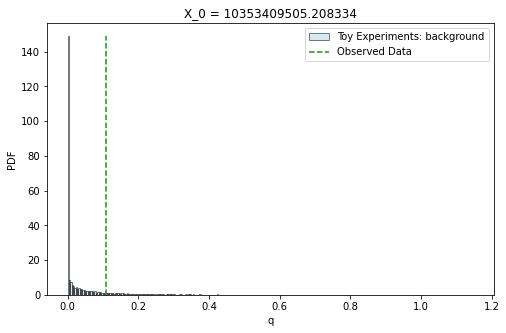

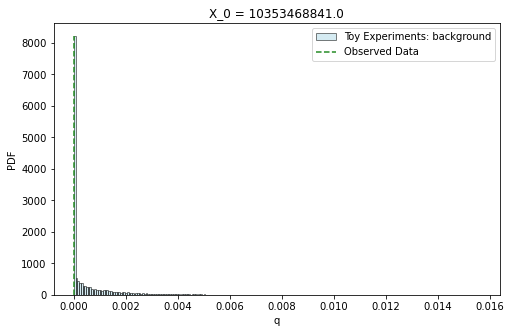

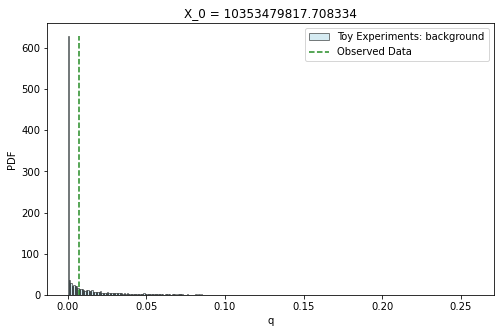

In [18]:
z_example, _ = stat.stat_test(run=395, x_0=[x0_max, center, freq[116]], mu_fix=0,
                              signal=fits.signal_gauss, n_toy=10000,
                              calc_z=True, calc_CI=False, draw=True, verbose=False, path='../datasets/')

### 3.2. Confidence Interval <a name="stats_ci"></a>

We are now interested in setting a limit on the strength of the signal, thus computing $\mu^{95\% CL}$. It would not be correct *a priori* to do both this and the previous staistical test, as they start from different assumptions on the presence of the signal or lack thereof; we will still be showing both for a more complete discussion.  

Due to computational constraints, $\mu^{95\% CL}$ is computed by scanning values of $\mu$ with a step of $\Delta \mu = 5$ and taking 1 in every 5 bins as a possible $x_0$. Given that the expected standard deviation of the signal is 14 bins, it is still an acceptable level of precision.  

As an example, we show the first 5 points.

Dataset loaded: ../datasets/AnalyzedDataFFT_Run_395_sliced.xlsx
Cavity frequency: 10353468841.0 Hz
fft subrun:2
Mu:  5    q(mu)_obs = 0.16700094464522408 
p_mu = 0.619   p_b = 0.714   ratio = 0.8669467787114846 

Mu:  10    q(mu)_obs = 1.0909082107370978 
p_mu = 0.524   p_b = 0.711   ratio = 0.7369901547116737 

Mu:  15    q(mu)_obs = 2.8225311305529885 
p_mu = 0.457   p_b = 0.711   ratio = 0.6427566807313644 

Mu:  20    q(mu)_obs = 5.361304881173055 
p_mu = 0.349   p_b = 0.711   ratio = 0.4908579465541491 

Mu:  35    q(mu)_obs = 17.81488916023818 
p_mu = 0.116   p_b = 0.712   ratio = 0.16292134831460675 

Mu:  40    q(mu)_obs = 23.576626364447748 
p_mu = 0.084   p_b = 0.712   ratio = 0.11797752808988765 

Mu:  45    q(mu)_obs = 30.142696551404697 
p_mu = 0.059   p_b = 0.712   ratio = 0.08286516853932584 

Mu:  50    q(mu)_obs = 37.512537402314365 
p_mu = 0.032   p_b = 0.712   ratio = 0.04494382022471911 

Mu:  60    q(mu)_obs = 54.661283901042225 
p_mu = 0.005   p_b = 0.712   ratio 

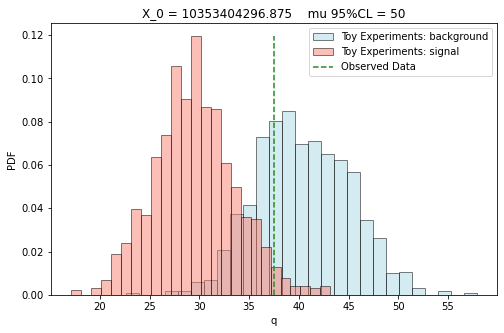

Mu:  5    q(mu)_obs = 0.18552117350327535 
p_mu = 0.772   p_b = 0.83   ratio = 0.9301204819277109 

Mu:  10    q(mu)_obs = 1.3542117746139866 
p_mu = 0.694   p_b = 0.829   ratio = 0.8371531966224367 

Mu:  15    q(mu)_obs = 3.5964122242016856 
p_mu = 0.601   p_b = 0.829   ratio = 0.7249698431845597 

Mu:  20    q(mu)_obs = 6.911335914523761 
p_mu = 0.502   p_b = 0.829   ratio = 0.6055488540410133 

Mu:  35    q(mu)_obs = 23.284589398305343 
p_mu = 0.245   p_b = 0.829   ratio = 0.2955367913148372 

Mu:  40    q(mu)_obs = 30.882552031577916 
p_mu = 0.172   p_b = 0.829   ratio = 0.2074788902291918 

Mu:  45    q(mu)_obs = 39.54931390537308 
p_mu = 0.117   p_b = 0.829   ratio = 0.1411338962605549 

Mu:  50    q(mu)_obs = 49.284092023659014 
p_mu = 0.085   p_b = 0.829   ratio = 0.10253317249698433 

Mu:  60    q(mu)_obs = 71.95456800973625 
p_mu = 0.041   p_b = 0.829   ratio = 0.049457177322074795 

Mu:  75    q(mu)_obs = 113.9508634010001 
p_mu = 0.006   p_b = 0.828   ratio = 0.00724637681

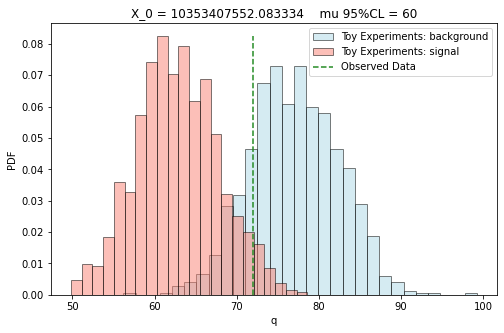

Mu:  5    q(mu)_obs = 0.2183619658135285 
p_mu = 0.834   p_b = 0.878   ratio = 0.949886104783599 

Mu:  10    q(mu)_obs = 1.6154283767623383 
p_mu = 0.796   p_b = 0.878   ratio = 0.9066059225512529 

Mu:  15    q(mu)_obs = 4.303189317778106 
p_mu = 0.713   p_b = 0.878   ratio = 0.8120728929384965 

Mu:  20    q(mu)_obs = 8.280693688463089 
p_mu = 0.647   p_b = 0.878   ratio = 0.7369020501138952 

Mu:  35    q(mu)_obs = 27.94216729413938 
p_mu = 0.412   p_b = 0.878   ratio = 0.46924829157175396 

Mu:  40    q(mu)_obs = 37.06914893450971 
p_mu = 0.29   p_b = 0.878   ratio = 0.33029612756264237 

Mu:  45    q(mu)_obs = 47.481129413272356 
p_mu = 0.244   p_b = 0.878   ratio = 0.27790432801822323 

Mu:  50    q(mu)_obs = 59.17716198988296 
p_mu = 0.202   p_b = 0.878   ratio = 0.23006833712984057 

Mu:  60    q(mu)_obs = 86.41760009604286 
p_mu = 0.091   p_b = 0.877   ratio = 0.10376282782212086 

Mu:  75    q(mu)_obs = 136.88502109721685 
p_mu = 0.018   p_b = 0.877   ratio = 0.0205245153933

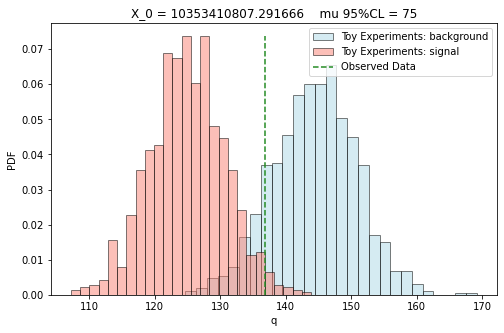

Mu:  5    q(mu)_obs = 0.2878885787906711 
p_mu = 0.81   p_b = 0.868   ratio = 0.9331797235023043 

Mu:  10    q(mu)_obs = 1.9183736767126902 
p_mu = 0.749   p_b = 0.868   ratio = 0.8629032258064516 

Mu:  15    q(mu)_obs = 4.987513419435118 
p_mu = 0.667   p_b = 0.868   ratio = 0.7684331797235023 

Mu:  20    q(mu)_obs = 9.494262769467241 
p_mu = 0.582   p_b = 0.868   ratio = 0.6705069124423962 

Mu:  35    q(mu)_obs = 31.629729917822033 
p_mu = 0.335   p_b = 0.868   ratio = 0.3859447004608295 

Mu:  40    q(mu)_obs = 41.87648308978055 
p_mu = 0.274   p_b = 0.868   ratio = 0.315668202764977 

Mu:  45    q(mu)_obs = 53.555632501345144 
p_mu = 0.188   p_b = 0.868   ratio = 0.21658986175115208 

Mu:  50    q(mu)_obs = 66.66613783816183 
p_mu = 0.166   p_b = 0.868   ratio = 0.1912442396313364 

Mu:  60    q(mu)_obs = 97.17705895370955 
p_mu = 0.072   p_b = 0.868   ratio = 0.08294930875576036 

Mu:  75    q(mu)_obs = 153.65264729979458 
p_mu = 0.01   p_b = 0.867   ratio = 0.0115340253748558

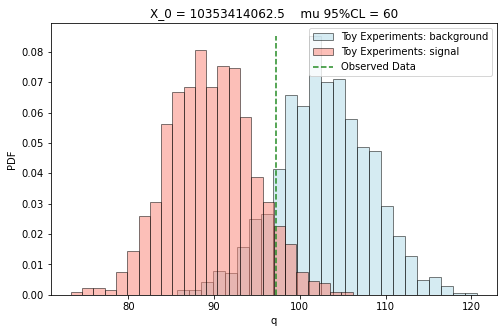

Mu:  5    q(mu)_obs = 0.4271078338576899 
p_mu = 0.668   p_b = 0.722   ratio = 0.925207756232687 

Mu:  10    q(mu)_obs = 2.331311887033735 
p_mu = 0.58   p_b = 0.722   ratio = 0.8033240997229917 

Mu:  15    q(mu)_obs = 5.759649738521148 
p_mu = 0.463   p_b = 0.722   ratio = 0.6412742382271469 

Mu:  20    q(mu)_obs = 10.711032603247759 
p_mu = 0.372   p_b = 0.722   ratio = 0.5152354570637119 

Mu:  35    q(mu)_obs = 34.69257562117173 
p_mu = 0.116   p_b = 0.722   ratio = 0.16066481994459836 

Mu:  40    q(mu)_obs = 45.72526694339922 
p_mu = 0.058   p_b = 0.722   ratio = 0.08033240997229918 

Mu:  45    q(mu)_obs = 58.275571538935765 
p_mu = 0.043   p_b = 0.722   ratio = 0.05955678670360111 

Mu:  50    q(mu)_obs = 72.34240549205447 
p_mu = 0.022   p_b = 0.722   ratio = 0.030470914127423823 

Mu:  60    q(mu)_obs = 105.02132985314597 
p_mu = 0.007   p_b = 0.722   ratio = 0.009695290858725763 

Mu:  75    q(mu)_obs = 165.38663517214854 
p_mu = 0.0   p_b = 0.722   ratio = 0.0 



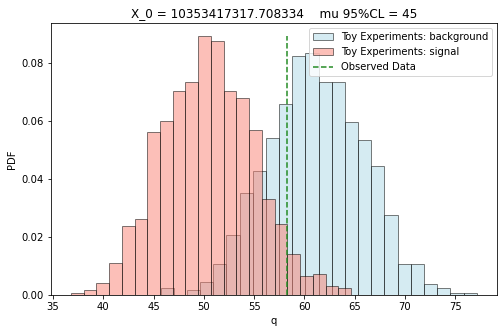

In [29]:
_, muCI_tot = stat.stat_test(run=395, x_0=freq[range(0, 25, 5)].values, mu_fix=[5,10,15,20,35,40,45,50,60,75],
                             signal=fits.signal_gauss, n_toy=1000,
                             calc_z=False, calc_CI=True, draw=True, verbose=True, path='../datasets/')

Finally the complete run along the whole frequency spectrum.

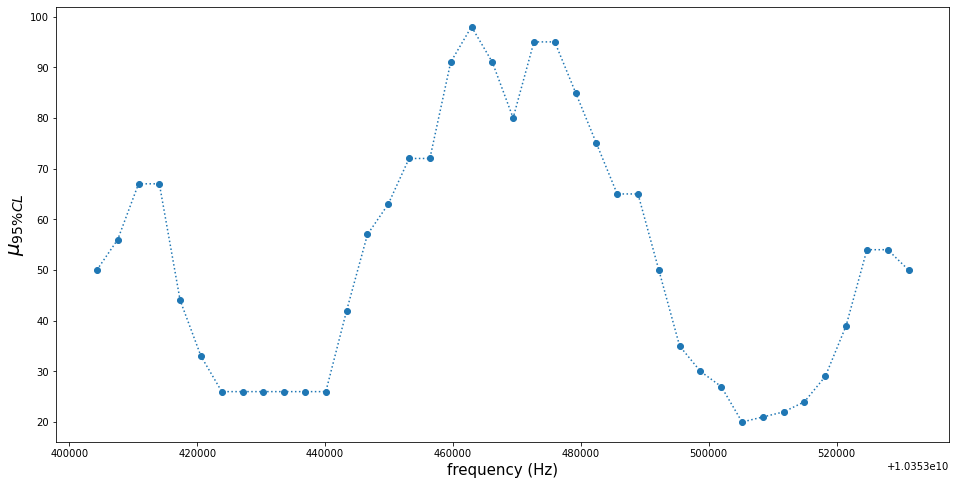

In [6]:
muCI1=np.array([50., 56., 67., 67., 44., 33., 26., 26., 26., 26.])
muCI2=np.array([26., 26., 42., 57., 63., 72., 72., 91., 98., 91.])
muCI3=np.array([80., 95., 95., 85., 75., 65., 65., 50., 35., 30.])
muCI4=np.array([27., 20., 21., 22., 24., 29., 39., 54., 54., 50.])
muCI_40values=np.array([muCI1,muCI2,muCI3,muCI4]).flatten()

freq_test=freq[(range(0,200,5))].values

fig,ax=plt.subplots(1,1,figsize=(16,8))

ax.scatter(freq_test,muCI_40values)
ax.plot(freq_test,muCI_40values,linestyle="dotted")
ax.set_xlabel("frequency (Hz)",size=15)
ax.set_ylabel(r'$\mu_{95\%CL}$',size=20)

plt.show()